# **Anomaly detection**

## Introduction   

New particles may be hiding in the LHC data, but what would they look like? There are many ideas. In this exercise, we focus on particles decaying to pairs of jets. In the standard model, jets are produced via gluon exchange:




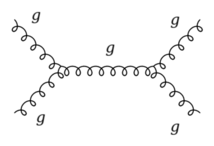

We could imagine other decays. For instance, a heavy particle Z' decaying to top quarks:

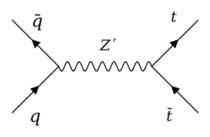

If the Z' is heavy enough, the top quarks will have a lot of energy and their decay products will all end up in the same jets. But these jets still look very different from gluon jets.

Of course this isn't the only possibility. Our particle could decay to more new particles of intermediate mass, resulting in jets with different properties:

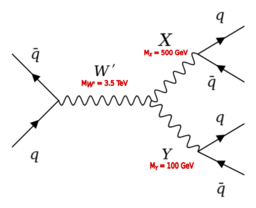

## Anomaly Detection

Since we don't know what the new particle looks like, we'll be looking for pairs of jets that look different from the gluon background. But before we do that, let's take a step back and talk about anomaly detection in a more general context.

Looking for anomalies in data is an ubiquitous task that occurs in many fields of research. However, the exact meaning of anomaly detection can vary: In modern machine learning literature, the phrase is often associated with **outlier detection**, i.e. identifying datapoints with extreme values in one or more features that are considered out-of-distribution. Since such datapoints are usually rare, they are also often referred to as **point anomalies**.

In Particle Physics, we are often interested in a different task: We are looking for a signal resonance that is buried under an overwhelmingly large background. Phrased differently, we are looking for a local accumulation of datapoints inside another distribution. This is referred to as **overdensity** or **group anomaly**, since usually multiple signal datapoints exist that form a coherent group inside the background distribution.

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_20dee87a3eab87e576231093c2ab76c5.png" width=80%>
</p>


## Supervised vs. Unsupervised methods

There are two major ways how to approach classification problems:
1. **Supervised** approaches: Simulate the signal and background processes and train a classifier on the simulated samples to distinguish them. Then apply the trained classifier on measured data.
2. **Unsupervised** approaches: Detect anomalies without using the truth-level information from signal and background labels. Again we can distinguish methods that use simple out-of-distribution scores to detect anomalous events and methods that are suited for group anomaly detection.

Supervised and unsupervised methods have different advantages and disadvantages. Of course, the major advantage of a fully supervised search is that it offers the best signal sensitivity. However, the sensitivity is only with respect to the particular signal model and cannot be extended to other signals or phase spaces easily. Also, there is a strong dependence on the correct simulation of the background, which can often be challenging - for example when considering QCD processes. Thus, covering all phase space regions and all possible signal models is unfeasible in terms of person and computational power.

The disadvantage of unsupervised methods is clearly that the signal sensitivity might not be optimal. However, they can be used in a completely **data-driven** way, without the need of complex Monte Carlo simulations. Also, it is possible to detect anomalies in a **model-agnostic** way, i.e. without looking for a *specific* signal model and to extend the search across many regions of phase space.

### Unsupervised out-of-distribution detection

These methods learn a "concept of normalitydensities" from the training data and then the anomaly score reflects how much other events deviate from this concept. For example, a model could be trained to learn the background e.g. from a "sideband" region of the phase space, where no signal events are expected and then for a signal-enriched sample from a "signal region" compute the deviation from the background as an anomaly score. An example for such a model is an **Autoencoder** which you will learn about in this exercise.

### Unsupervised group anomaly detection

Identifying group anomalies is much more difficult than identifying point anomalies, in particular if their contribution to the overall data distribution is as small as in a Particle Physics case. The most powerful test to distinguish signal and background is - according to the [Neyman-Pearson lemma](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) - based on the **likelihood ratio** of signal and background:

$$R(\boldsymbol{x})=\frac{p_{\mathrm{sig}}(\boldsymbol{x})}{p_{\mathrm{bg}}(\boldsymbol{x})}$$

The major challenge in anomaly detection is to find an estimate of the very small signal contribution $p_{\mathrm{sig}}(\boldsymbol{x})$. At the same time, we also need a reliable and precise method to estimate our background density, $p_{\mathrm{bg}}(\boldsymbol{x})$.

As already mentioned, it is usually impossible to directly estimate $p_{\mathrm{sig}}(\boldsymbol{x})$ in a practical Particle Physics search. Instead, one can estimate the density of the combined signal and background densities (i.e. $p_{\mathrm{sig+bg}}(\boldsymbol{x})$) from a "signal region", where we expect most of the signal to be located, and the background-only density from a "sideband" where no signal is expected. Then again one uses the likelihood ratio of these densities ($R_{\mathrm{uns}}(\boldsymbol{x})$) to distinguish signal and background. If we assume $p_{\mathrm{sig+bg}}(\boldsymbol{x})=p_{\mathrm{sig}}(\boldsymbol{x})+p_{\mathrm{bg}}(\boldsymbol{x})$, the resulting likelihood ratio $R_{\mathrm{uns}}(\boldsymbol{x})$ should show the same behavior as the original $R(\boldsymbol{x})$ (i.e. it takes high values for signal-like events and low values for background-like events).

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_db52cc731f3e5c38d42df49ba30743ba.png" width=60%>
</p>


In this exercise, we will introduce two unsupervised anomaly detection methods: **weak supervision** and **autoencoders**.

## Exercise 1: Weakly supervised methods

Methods using weak supervision are supervised trainings on labels that are "noisy": The labels we train our models on do not contain the full signal/background information, but make use of a "proxy" classification task, that yields a similar result.

As mentioned above, we divide our phase space into two regions: A "signal region", where we expect the majority of signal to reside and the "sidebands" which contain almost no signal. We then assign labels to the events based on which of the regions they are located in: Events in the signal region are assigned the "positive" label and events in the sidebands are assigned the "negative" label. Finally, we train a classifier (e.g. a deep neural network) to distinguish these two.

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_1d0313356ba991e634d09efce7140618.png" width=30%>
</p>


Essentially, we are distinguishing two samples containing different **signal fractions**: While the signal region sample should contain a relatively high amount of signal samples, we expect only very few signal events in the sideband sample. Since the majority of events in both samples is still background, this method of assigning labels is "noisy", as a significant proportion of the training will consist of distinguishing background events from other background events.

However, this method can be used in a completely **data-driven** way, as no prior knowledge about the true labels is necessary. Therefore, this method is also referred to as **Classification without Labels (CWoLa)** [https://doi.org/10.1007/JHEP10%282017%29174 ]. In the paper introducing CWoLa, it has been shown that the optimal classifier distinguishing signal vs. background is the same as the optimal classifier distinguishing between signal region vs. sideband events under the condition of a higher signal fraction in the signal region sample. This means under ideal conditions, we should be able to detect signal events in an unsupervised, model-independent way.

However, the CWoLa approach also has limitations: it only works for input features that don't have strong correlations with the invariant mass in which the signal that we look for is resonant and the input feature distributions need to be similar between the signal region and the sidebands.

A CWoLa model for distinguishing signal and background will be trained in a completely **unsupervised** way.

In [ ]:
!pip install nflows torchdyn vector

In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import h5py as h5

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


We use the LHCO 2020 challenge R&D dataset (https://lhco2020.github.io/homepage/). It consists of 1,000,000 simulated QCD multijet events in addition to a signal process (100,000 events) of a W' boson with a mass of $m_{W'} = 3.5$ TeV decaying into an X boson ($m_{X} = 500$ GeV) and a Y boson ($m_{Y} = 100$ GeV). Specifically, we use the high-level features set, which contains the 4-momenta of the two leading jets, their (1,2,3) subjettiness and a label denoting whether the event is a signal (1) or background (0) process.

So let's first download the dataset.

In [ ]:
!wget https://zenodo.org/record/4536377/files/events_anomalydetection_v2.features.h5

--2025-11-09 19:54:31--  https://zenodo.org/record/4536377/files/events_anomalydetection_v2.features.h5
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.48.75, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4536377/files/events_anomalydetection_v2.features.h5 [following]
--2025-11-09 19:54:32--  https://zenodo.org/records/4536377/files/events_anomalydetection_v2.features.h5
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 74315238 (71M) [application/octet-stream]
Saving to: ‘events_anomalydetection_v2.features.h5.5’

events_anomalydetec 100%[===================>]  70.87M  20.1MB/s    in 4.5s    

2025-11-09 19:54:37 (15.7 MB/s) - ‘events_anomalydetection_v2.features.h5.5’ saved [74315238/74315238]



We now order the two jets by mass, such that $m_{j1} \leq m_{j2}$. Then we extract four interesting features, which might capture anomalous substructure: $m_{j1}$, $m_{j2}-m_{j1}$, $\tau_{21,j1}$, $\tau_{21,j2}$. Moreover, we want to reduce the contribution of the signal to something realistically small. We go down to 1,000 events. We put the remaining 99,000 aside for the evaluation later.

In [ ]:
import vector

def deltaR(features):
  j1_vec = vector.array({
      "px": np.array(features[["pxj1"]]),
      "py": np.array(features[["pyj1"]]),
      "pz": np.array(features[["pzj1"]]),
  })
  j2_vec = vector.array({
      "px": np.array(features[["pxj2"]]),
      "py": np.array(features[["pyj2"]]),
      "pz": np.array(features[["pzj2"]]),
  })
  return j1_vec.deltaR(j2_vec).flatten()

In [ ]:
n_sig = 1000

features = pd.read_hdf("events_anomalydetection_v2.features.h5")
mj1mj2 = np.array(features[['mj1','mj2']])
tau21 = np.array(features[['tau2j1','tau2j2']]) / (1e-5+np.array(features[['tau1j1','tau1j2']]))

# Sorting of mj1 and mj2:
mjmin = mj1mj2[range(len(mj1mj2)), np.argmin(mj1mj2, axis=1)]
mjmax = mj1mj2[range(len(mj1mj2)), np.argmax(mj1mj2, axis=1)]

# Then we do the same sorting for the taus
tau21min = tau21[range(len(mj1mj2)), np.argmin(mj1mj2, axis=1)]
tau21max = tau21[range(len(mj1mj2)), np.argmax(mj1mj2, axis=1)]

# compute the dijet invariant mass
pjj = np.array(features[['pxj1','pyj1','pzj1']]) + np.array(features[['pxj2', 'pyj2', 'pzj2']])
Ejj = (np.sqrt(np.sum(np.array(features[['pxj1', 'pyj1', 'pzj1', 'mj1']])**2, axis=1))
       + np.sqrt(np.sum(np.array(features[['pxj2', 'pyj2', 'pzj2', 'mj2']])**2, axis=1)))

mjj = np.sqrt(Ejj**2 - np.sum(pjj**2, axis=1))
Rjj = deltaR(features)

ptj1 = np.sqrt(np.array(features[['pxj1']])**2 + np.array(features[['pyj1']])**2).flatten()
ptj2 = np.sqrt(np.array(features[['pxj2']])**2 + np.array(features[['pyj2']])**2).flatten()
pt_asym = np.abs(ptj1 - ptj2) / (ptj1 + ptj2)

# collect the features into a dataset, plus mark signal/bg with 1/0
data_columns = [
    mjj / 1000, # converting GeV to TeV
    mjmin / 1000,
    (mjmax - mjmin) / 1000,
    tau21min,
    tau21max,
    Rjj,
    pt_asym,
    np.array(features['label'])
]
full_dataset = np.dstack((data_columns))[0]

# reduce the signal amount and shuffle
dataset_bkg = full_dataset[full_dataset[:, -1] == 0]
dataset_sig = full_dataset[full_dataset[:, -1] == 1]
np.random.seed(42)  # fixing the seed to get deterministic results
np.random.shuffle(dataset_sig)
dataset = np.vstack((dataset_bkg, dataset_sig[:n_sig]))
dataset_extrasig = dataset_sig[n_sig:]  # remaining signal can be used for evaluation later
np.random.shuffle(dataset)


Let's plot these features along with the dijet invariant mass.

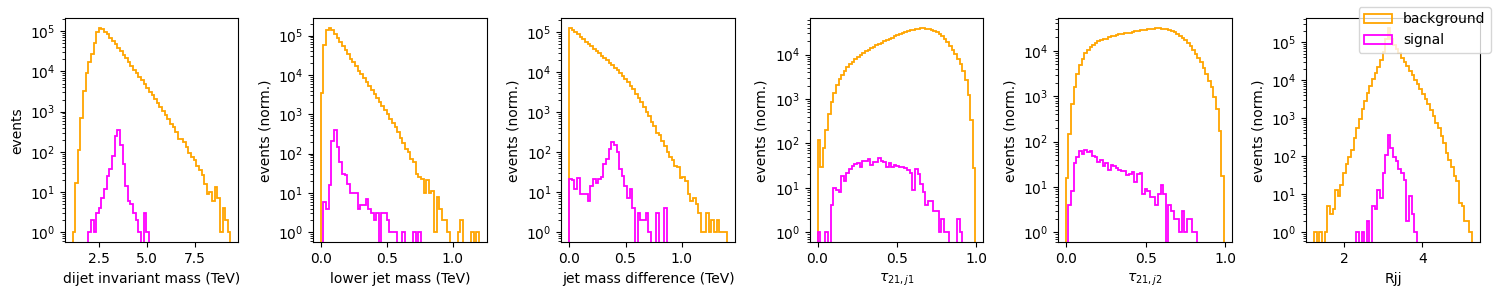

In [ ]:
n_bins = 60
bkg_color = "orange"
signal_color = "fuchsia"

label_map = {0: "dijet invariant mass (TeV)",
             1: "lower jet mass (TeV)",
             2: "jet mass difference (TeV)",
             3: r"$\tau_{21,j1}$",
             4: r"$\tau_{21,j2}$",
             5: "Rjj"}

fig, ax = plt.subplots(1, 6, figsize=(15, 3))

for i in range(6):
  if i==0:
    ylabel = "events"
  else:
    ylabel = "events (norm.)"

  _, common_bins, _ = ax[i].hist(dataset[:, i][dataset[:, -1] == 0], n_bins, label="background", edgecolor=bkg_color, linewidth=1.3, histtype="step")

  ax[i].hist(dataset[:, i][dataset[:, -1] == 1], common_bins, label="signal", edgecolor=signal_color, linewidth=1.3, histtype="step")
  ax[i].set_xlabel(label_map[i])
  ax[i].set_ylabel(ylabel)
  ax[i].set_yscale("log")

leg_handles, leg_labels = ax[1].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

Rjj(deltaR) is highly correlated with mass (GeV)
our accuracy is really low, our model can't estimate background/differenciate between signal and background -> we have a really bad estimate of background

We see that this kind of signal would result in a thin resonant peak at the particle mass (3.5 TeV). Also, the substructure features would have some discrimination power between the signal and the background. However, rather than directly optimizing cuts based on known truth information, we want to employ CWoLa. As a first step, we need to define our signal region (SR) and our sidebands (SB). For simplicity, we set the SR now around where the signal acutally lies (in a realistic scenario, we would scan it over different positions). The SB should be chosen in a way to have similar substructure distributions as the SR, while keeping as many training events as possible. If we choose them too wide, we will see differences and CWoLa won't work.

The snippet below cuts the dataset into SR and lower/upper SB.

In [ ]:
# split into SR and SB

SR = (3.3, 3.7)  # SR boundary in TeV
SB_low = (3.1, 3.3)  # same for upper and lower SB
SB_high = (3.7, 3.9)

SR_data = dataset[(dataset[:, 0] > SR[0]) & (dataset[:, 0] <= SR[1])]
SB_low_data = dataset[(dataset[:, 0] > SB_low[0]) & (dataset[:, 0] <= SB_low[1])]
SB_high_data = dataset[(dataset[:, 0] > SB_high[0]) & (dataset[:, 0] <= SB_high[1])]

We can then check how this affects the distributions of our substructure variables by plotting the regions separately.

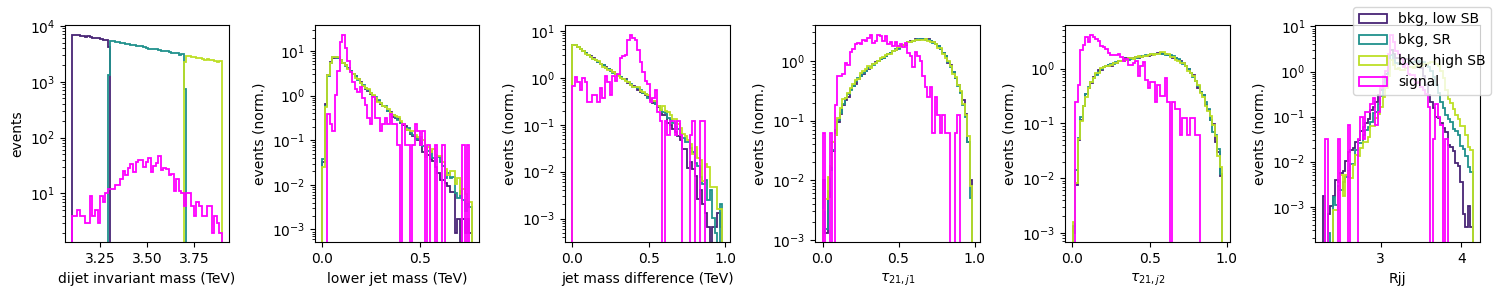

In [ ]:
n_bins = 60
SB_low_color = "#482475"
SR_color = "#20918c"
SB_high_color = "#bddf26"
signal_color = "fuchsia"

fig, ax = plt.subplots(1, 6, figsize=(15, 3))

common_bins = np.linspace(SB_low[0], SB_high[1], n_bins)

for i in range(6):
  if i == 0:
    density = False
    ylabel = "events"
  else:
    density = True
    ylabel = "events (norm.)"
    common_bins = n_bins

  _, common_bins, _ = ax[i].hist(SB_low_data[:, i][SB_low_data[:, -1] == 0], common_bins, label="bkg, low SB", edgecolor=SB_low_color, linewidth=1.3, histtype="step", density=density)
  ax[i].hist(SR_data[:, i][SR_data[:, -1] == 0], common_bins, label="bkg, SR", edgecolor=SR_color, linewidth=1.3, histtype="step", density=density)
  ax[i].hist(SB_high_data[:, i][SB_high_data[:, -1] == 0], common_bins, label="bkg, high SB", edgecolor=SB_high_color, linewidth=1.3, histtype="step", density=density)
  ax[i].hist(dataset[:, i][dataset[:, -1] == 1], common_bins, label="signal", edgecolor=signal_color, linewidth=1.3, histtype="step", density=density)
  ax[i].set_xlabel(label_map[i])
  ax[i].set_ylabel(ylabel)
  ax[i].set_yscale("log")

leg_handles, leg_labels = ax[1].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

Now let's set up a simple feed-forward neural network classifier using `PyTorch`.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, n_inputs):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)     # regularization
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

As usual, we should divide the data into training, validation and test data. Also, we want to apply the standard scaler transformation (subtract mean, divide by standard deviation) to make the learning task easier for the network. We extract the signal-vs-background truth information here too, but only for the evaluation later. It will not be used during training. `y_train` only refers to whether an event comes from the SR or from the SB.

In [ ]:
# limit to the substructure features and label SR data with 1 and SB data with 0
stacked_data = np.vstack((SR_data, SB_low_data, SB_high_data))
y_data = np.concatenate((np.ones(len(SR_data)), np.zeros(len(SB_low_data)), np.zeros(len(SB_high_data))))

stacked_data, y_data = shuffle(stacked_data, y_data, random_state=42)
signal_labels = stacked_data[:, -1]
X_data = stacked_data[:, 1:-1]

# split into train/validation/test parts with proportions 3:1:2
X_train = X_data[:X_data.shape[0]//2]
y_train = y_data[:X_data.shape[0]//2]
X_val = X_data[X_data.shape[0]//2:2*X_data.shape[0]//3]
y_val = y_data[X_data.shape[0]//2:2*X_data.shape[0]//3]
X_test = X_data[2*X_data.shape[0]//3:]
y_test = y_data[2*X_data.shape[0]//3:]

# add extra signal to test set and remove the SB data
X_test = np.vstack((X_test[y_test == 1], dataset_extrasig[:, 1:-1]))
signal_labels_test = np.concatenate((signal_labels[2*X_data.shape[0]//3:][y_test == 1], np.ones(dataset_extrasig.shape[0])))

# rescale features to mean of 0 and standard deviation of 1
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# while at it, also extract and rescale the extra signal sample
X_extrasig = (dataset_extrasig[:, 1:-1][(dataset_extrasig[:, 0] > SR[0]) & (dataset_extrasig[:, 0] <= SR[1])] - mean) / std

In [ ]:
# train
classifier = NeuralNet(X_train.shape[1]).to(device)  # infer the number of inputs from the columns in X_train
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0005)
criterion = nn.functional.binary_cross_entropy

n_epochs = 20
batch_size = 128

n_batches = int(X_train.shape[0]/batch_size)

train_losses = []
val_losses = []

for ep in range(n_epochs):
    for i in range(n_batches):

        optimizer.zero_grad()
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size

        x = torch.tensor(X_train[i_start: i_stop], dtype=torch.float).to(device)
        y = torch.tensor(y_train[i_start: i_stop], dtype=torch.float).to(device)

        net_out = classifier(x)
        loss = criterion(net_out.flatten(), y)
        loss.backward()
        optimizer.step()


    # Calculate predictions for the full training and validation sample
    y_pred_train = classifier(torch.tensor(X_train, dtype=torch.float).to(device)).detach().cpu().numpy().flatten()
    y_pred_val = classifier(torch.tensor(X_val, dtype=torch.float).to(device)).detach().cpu().numpy().flatten()

    # Calculate aver loss / example over the epoch
    train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float).to(device), torch.tensor(y_train, dtype=torch.float).to(device))
    val_loss = criterion(torch.tensor(y_pred_val, dtype=torch.float).to(device), torch.tensor(y_val, dtype=torch.float).to(device))

    # print some information
    print("Epoch:", ep, "Train Loss:", train_loss.item(),  "Test Loss:", val_loss.item())

    # and store the losses for later use
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())


Epoch: 0 Train Loss: 0.6866775751113892 Test Loss: 0.6873438358306885
Epoch: 1 Train Loss: 0.6806667447090149 Test Loss: 0.6813257336616516
Epoch: 2 Train Loss: 0.6790345907211304 Test Loss: 0.6793281435966492
Epoch: 3 Train Loss: 0.6781716346740723 Test Loss: 0.6788673996925354
Epoch: 4 Train Loss: 0.677588701248169 Test Loss: 0.6789137125015259
Epoch: 5 Train Loss: 0.6772395372390747 Test Loss: 0.6776441335678101
Epoch: 6 Train Loss: 0.6769615411758423 Test Loss: 0.6779638528823853
Epoch: 7 Train Loss: 0.6768723130226135 Test Loss: 0.6782552599906921
Epoch: 8 Train Loss: 0.676529586315155 Test Loss: 0.6767749190330505
Epoch: 9 Train Loss: 0.6763675808906555 Test Loss: 0.6771851778030396
Epoch: 10 Train Loss: 0.6760477423667908 Test Loss: 0.677151083946228
Epoch: 11 Train Loss: 0.6760029196739197 Test Loss: 0.6770341992378235
Epoch: 12 Train Loss: 0.6759876012802124 Test Loss: 0.6767756938934326
Epoch: 13 Train Loss: 0.6759418845176697 Test Loss: 0.6769811511039734
Epoch: 14 Train Los

We can now check if the classifier that we trained to distinguish SR from SB events actually knows how to tell apart signal from background using truth information. Let's draw a ROC curve and a significance improvement characteristic (SIC). The latter is a measure for how much the significance ($S/\sqrt{B}$ where $S$ is the number of signal and $B$ the number of background events) improves for a cut on our classifier with respect to the original significance in our dataset without the application of any cut. Hopefully, it does better than a random classifier.

/tmp/ipython-input-3450018535.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(tpr, 1/fpr, label="CWoLa")
/tmp/ipython-input-3450018535.py:8: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(tpr, 1/tpr, linestyle=":", color="black", label="random")
/tmp/ipython-input-3450018535.py:13: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(tpr, tpr/(fpr**0.5), label="CWoLa")


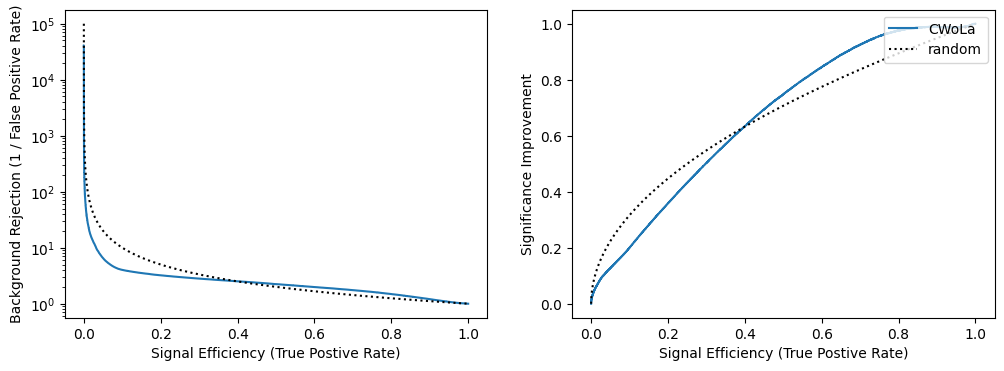

In [ ]:
# evaluate

y_pred_test = classifier(torch.tensor(X_test, dtype=torch.float).to(device)).detach().cpu().numpy().flatten()
fpr, tpr, thr = roc_curve(signal_labels_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(tpr, 1/fpr, label="CWoLa")
ax[0].plot(tpr, 1/tpr, linestyle=":", color="black", label="random")
ax[0].set_xlabel("Signal Efficiency (True Postive Rate)")
ax[0].set_ylabel("Background Rejection (1 / False Positive Rate)")
ax[0].set_yscale("log")

ax[1].plot(tpr, tpr/(fpr**0.5), label="CWoLa")
ax[1].plot(tpr, tpr**0.5, linestyle=":", color="black", label="random")
ax[1].set_xlabel("Signal Efficiency (True Postive Rate)")
ax[1].set_ylabel("Significance Improvement")
ax[1].legend(loc="upper right")
plt.show()

We see that this construction yields a classifier that has sensitivity to a resonant signal with anomalous substructure, without using any truth labels during training. We omitted some tweaks that one would apply to increase the sensitivity even more, such as applying a weight during training to give the SR events equal total importance as the SB and the lower SB to count as much as the higher SB (currently the lower SB is more populated than the higher one).

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Farklı threshold değerlerinde metrikler
thresholds_to_test = [0.3, 0.5, 0.7]

print("="*60)
print("CWoLa Classifier Performance Metrics")
print("="*60)

for thresh in thresholds_to_test:
    y_pred_binary = (y_pred_test > thresh).astype(int)

    acc = accuracy_score(signal_labels_test, y_pred_binary)
    prec = precision_score(signal_labels_test, y_pred_binary)
    rec = recall_score(signal_labels_test, y_pred_binary)
    f1 = f1_score(signal_labels_test, y_pred_binary)

    print(f"\nThreshold = {thresh}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# AUC skoru
auc = roc_auc_score(signal_labels_test, y_pred_test)
print(f"\nAUC Score: {auc:.4f}")

# Confusion matrix (threshold=0.5 için)
y_pred_binary = (y_pred_test > 0.5).astype(int)
cm = confusion_matrix(signal_labels_test, y_pred_binary)
print(f"\nConfusion Matrix (threshold=0.5):")
print(f"                 Predicted")
print(f"               Bkg    Sig")
print(f"Actual Bkg  [{cm[0,0]:5d}  {cm[0,1]:5d}]")
print(f"       Sig  [{cm[1,0]:5d}  {cm[1,1]:5d}]")

# Signal efficiency ve background rejection için özel noktalar
signal_effs = [0.3, 0.5, 0.7, 0.9]
print("\nSignal Efficiency → Background Rejection:")
for sig_eff in signal_effs:
    idx = np.argmin(np.abs(tpr - sig_eff))
    bkg_rej = 1/fpr[idx]
    print(f"  ε_sig = {sig_eff:.1f} → 1/ε_bkg = {bkg_rej:.2f}")

print("="*60)

CWoLa Classifier Performance Metrics

Threshold = 0.3
  Accuracy:  0.7089
  Precision: 0.7103
  Recall:    0.9962
  F1-Score:  0.8293

Threshold = 0.5
  Accuracy:  0.3439
  Precision: 0.6143
  Recall:    0.2035
  F1-Score:  0.3057

Threshold = 0.7
  Accuracy:  0.2874
  Precision: 0.4013
  Recall:    0.0079
  F1-Score:  0.0155

AUC Score: 0.5144

Confusion Matrix (threshold=0.5):
                 Predicted
               Bkg    Sig
Actual Bkg  [27882  12686]
       Sig  [79058  20202]

Signal Efficiency → Background Rejection:
  ε_sig = 0.3 → 1/ε_bkg = 2.81
  ε_sig = 0.5 → 1/ε_bkg = 2.24
  ε_sig = 0.7 → 1/ε_bkg = 1.75
  ε_sig = 0.9 → 1/ε_bkg = 1.21


We will add another feature to the classifier inputs: the angular distance between the two jets $\Delta R_{jj}$. Below is a function that computes it and can be integrated into the data preprocessing block. It runs directly on the pandas dataframe `features`. To make our lives easier, we make use of the `vector` python package, which we need to install first.

In [ ]:
import vector

def deltaR(features):
  j1_vec = vector.array({
      "px": np.array(features[["pxj1"]]),
      "py": np.array(features[["pyj1"]]),
      "pz": np.array(features[["pzj1"]]),
  })
  j2_vec = vector.array({
      "px": np.array(features[["pxj2"]]),
      "py": np.array(features[["pyj2"]]),
      "pz": np.array(features[["pzj2"]]),
  })
  return j1_vec.deltaR(j2_vec).flatten()

## Autoencoder-based methods

Another family of methods for unsupervised anomaly detection is using **Autoencoders**. These are deep learning models that consist of three parts: An **encoder**, a **decoder** and a **bottleneck**. The encoder takes the input data and transforms it into a lower-dimensional representation, also referred to as the **latent space**, which also serves as the above mentioned bottleneck. The decoder then takes the information from the latent space and transforms it back into the original input dimension. This model is then trained such that the (mean squared) difference between input and output is minimized.

<p align="center">
<img src="https://s3.desy.de/hackmd/uploads/upload_626e3254c6f5847a781c0d0ee415d22f.png" width=60%>
</p>

The reasoning behind such models is that we would like to learn a method that can capture the underlying distribution of a high dimensional input space based on way fewer latent space variables.

Autoencoders can also be used for anomaly detection purposes: We train a model to compress and decompress background events. A such trained Autoencoder will yield a low loss (i.e. mean squared difference between input and output) for background events, as it has been trained to do so. However, as soon as we present the model with a different event such as an anomalous signal, the Autoencoder does not know how to compress and decompress the input correctly any more, which will yield a high loss value. Thus, one can use the loss value to distinguish signal from background.

Similar to weak classification, this can be done in a **completely data-driven way**: For example, we can again divide our phase space into signal region and sidebands to obtain a high purity background sample, train an Autoencoder on events from the sidebands and evaluate on the signal region. Another option would be to train on the whole phase space, since Autoencoders have shown to be very robust against small contaminations of signal, which is usually the case in modern Particle Physics problems.

Because Autencoders have a built-in compression into a low-dimensional latent space, they are particularly well suited for high-dimensional inputs, such as (jet) images or point clouds (e.g. sets of particle flow constituents) and we will use an **autoencoder** for unsupervised anomaly detection.

## Download the necessary data files

In [7]:
!wget -O background.h5 https://wolke.physnet.uni-hamburg.de/index.php/s/LxRxH94MTPpjKMX/download
!wget -O signal.h5 https://wolke.physnet.uni-hamburg.de/index.php/s/z96QkTr9oxAeLEi/download

--2025-11-09 20:17:14--  https://wolke.physnet.uni-hamburg.de/index.php/s/LxRxH94MTPpjKMX/download
Resolving wolke.physnet.uni-hamburg.de (wolke.physnet.uni-hamburg.de)... 134.100.106.8
Connecting to wolke.physnet.uni-hamburg.de (wolke.physnet.uni-hamburg.de)|134.100.106.8|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://wolke.physnet.uni-hamburg.de/public.php/dav/files/LxRxH94MTPpjKMX/?accept=zip [following]
--2025-11-09 20:17:14--  https://wolke.physnet.uni-hamburg.de/public.php/dav/files/LxRxH94MTPpjKMX/?accept=zip
Reusing existing connection to wolke.physnet.uni-hamburg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 578718505 (552M) [application/octet-stream]
Saving to: ‘background.h5’

background.h5       100%[===================>] 551.91M  31.1MB/s    in 18s     

2025-11-09 20:17:32 (30.7 MB/s) - ‘background.h5’ saved [578718505/578718505]

--2025-11-09 20:17:33--  https://wolke.physnet.uni-hamburg.de/index.php/s/z96QkTr9

## Load the Data

The datasets used in this part contain $33\times33\,\text{px}$ images produced from the heaviest jet in each event. The images represent projections of the jet contents in the $(\eta, \phi)$ plane. Their orientation is normalized by rotating and flipping in the $(\eta, \phi)$.

To enhance the expected signal fraction, a preselection is performed by requiring the invariant mass of the jet pair to be within $650\,\text{GeV}$ of the mass of our signal ($3.5\,\text{TeV}$).

In [8]:
def load(file_name):
    """
    Loads data from a file and converts it to the format we'll need for the autoencoder.
    """

    return torch.tensor(h5.File(file_name)["j1_images"]).float()[:, np.newaxis, :, :].to(device)

In [11]:
background = load("background.h5")
signal = load("signal.h5")

In [12]:
print(len(background), len(signal))

253622 88967


We start by plotting a few jets from each dataset to get an idea of what they look like. The difference is actually visible by eye.

In [13]:
def plot_jet(jet):
    """
    Plots a jet image and show it.
    """

    from matplotlib import colors

    norm = colors.LogNorm(1e-3, 1, clip='True')

    plt.imshow(jet.cpu(), norm=norm, origin="lower")

    plt.xlabel(r"$i_\eta'$")
    plt.ylabel(r"$i_\phi'$")
    plt.colorbar(label="Energy (normalized to one)")
    plt.show()

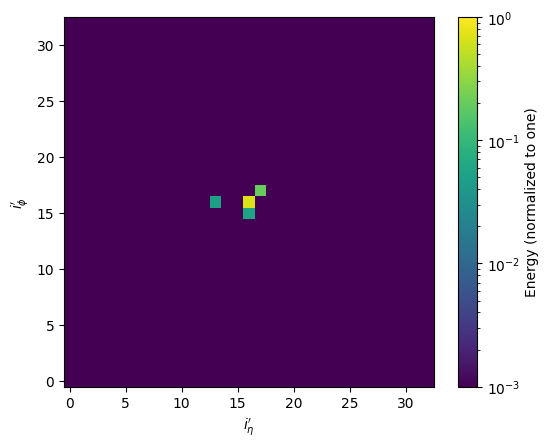

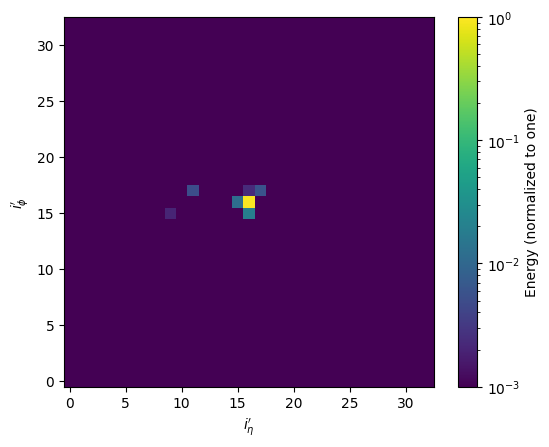

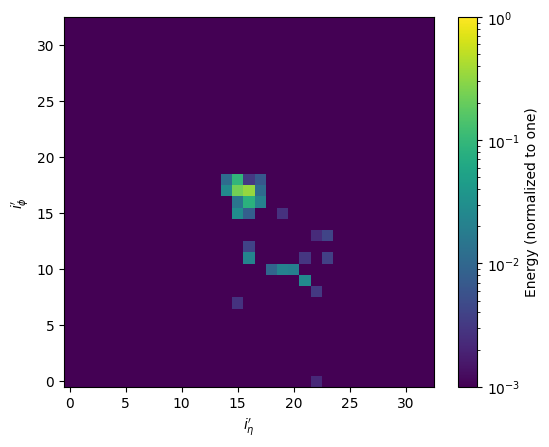

In [ ]:
for i in range(3):
    plot_jet(background[i, 0])

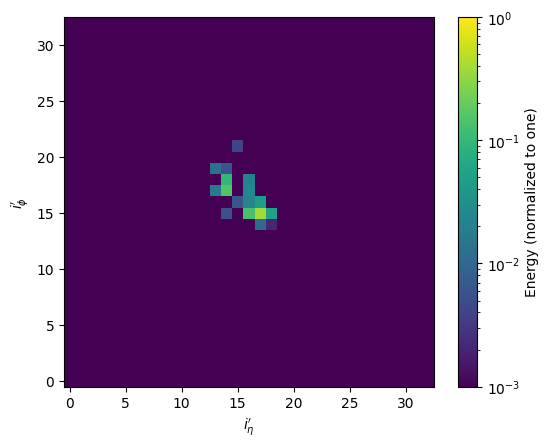

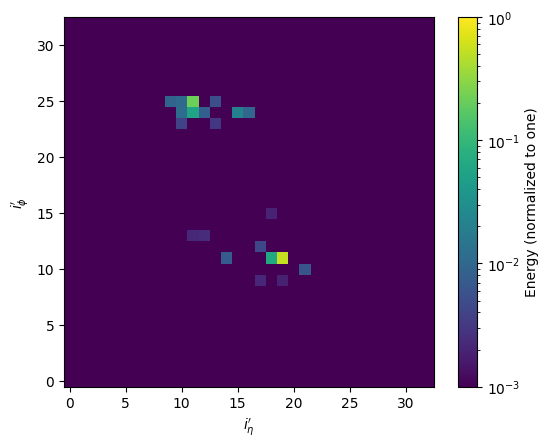

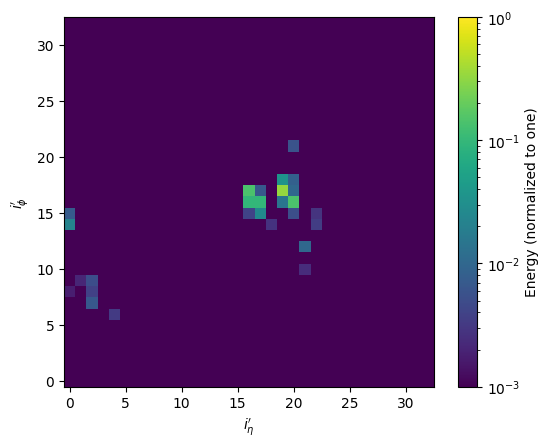

In [ ]:
for i in range(3):
    plot_jet(signal[i, 0])

Model

Our autoencoder is defined below. The architecture is heavily inspired from [2203.01343](https://arxiv.org/abs/2203.01343).


In [14]:
def make_model(latent_space_dims=5, npix=33):
    sample_factor = 3

    encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(sample_factor),

        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 1, kernel_size=3, padding=1),
        nn.ELU(),

        nn.Flatten(),
        nn.Linear((npix // sample_factor)**2, 100),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(100, latent_space_dims),
        nn.ReLU())

    decoder = nn.Sequential(
        nn.Linear(latent_space_dims, 100),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(100, (npix // sample_factor)**2),
        nn.ReLU(),

        nn.Unflatten(1, (1, (npix // sample_factor), (npix // sample_factor))),

        nn.Conv2d(1, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),

        nn.Upsample(scale_factor=sample_factor),

        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ELU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 1, kernel_size=3, padding=1),
        nn.ELU())

    return nn.Sequential(encoder, decoder).to(device), encoder.to(device), decoder.to(device)

In [15]:
autoencoder, _, _ = make_model()

## Training

To train the autoencoder, we use the Mean Square Error loss, $\text{MSE}(\vec x, \vec y)\equiv\langle (\vec x - \vec y)^2 \rangle,$ between the input images and what the network returns. The MSE is 0 if the input and output are equal, and increases when differences are bigger.

In [16]:
def MSE(truth, decoded):
    return ((truth - decoded)**2).mean((-1, -2, -3))

def train(autoencoder, data, *, lr=1e-3, epochs=30, batch_size=128):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

    for epoch in range(epochs):
        loss_sum = 0

        for i in range(len(data) // batch_size):
            batch = data[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = MSE(batch, autoencoder(batch)).mean()
            loss.backward()
            optimizer.step()

            loss_sum += loss.detach().cpu().item()

        print(f"Epoch {epoch:2d}: training loss = {loss_sum}")

We start by training on background jets only, using a small subset of the data for speed (the impact on the performance is minimal). Usually, autoencoder training is not sensitive to a small fraction of signal being injected (fear not, we'll check that in a moment).

In [ ]:
train(autoencoder, background[:12800])

Epoch  0: training loss = 1.534866563975811
Epoch  1: training loss = 0.08987182524288073
Epoch  2: training loss = 0.05417788872728124
Epoch  3: training loss = 0.04286231618607417
Epoch  4: training loss = 0.03836911701364443
Epoch  5: training loss = 0.0352140492759645
Epoch  6: training loss = 0.032879279635380954
Epoch  7: training loss = 0.03104760404676199
Epoch  8: training loss = 0.0295412678970024
Epoch  9: training loss = 0.028145958145614713
Epoch 10: training loss = 0.026701971190050244
Epoch 11: training loss = 0.025313482459750958
Epoch 12: training loss = 0.024091241677524522
Epoch 13: training loss = 0.023025163653073832
Epoch 14: training loss = 0.02211494384391699
Epoch 15: training loss = 0.021352668511099182
Epoch 16: training loss = 0.02070417083450593
Epoch 17: training loss = 0.020151121731032617
Epoch 18: training loss = 0.01961022664909251
Epoch 19: training loss = 0.019124196594930254
Epoch 20: training loss = 0.018729302697465755
Epoch 21: training loss = 0.

In [17]:
@torch.no_grad()
def plot_jet_reconstruction(autoencoder, jet):
    """
    Plots a jet image and its reconstruction by an autoencoder, and show both.
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    norm = colors.LogNorm(1e-3, 1, clip='True')

    plt.sca(ax1)
    plt.imshow(jet[0, 0].cpu(), norm=norm, origin="lower")
    plt.title("Original")
    plt.ylabel(r"$i_\phi'$")
    plt.xlabel(r"$i_\eta'$")

    plt.sca(ax2)
    plt.imshow(autoencoder(jet)[0, 0].cpu(), norm=norm, origin="lower")
    plt.title("AE Output")
    plt.xlabel(r"$i_\eta'$")

    plt.sca(ax3)
    plt.imshow((jet - autoencoder(jet)).abs()[0, 0].cpu(), norm=norm, origin="lower")
    plt.title("Absolute Difference")
    plt.xlabel(r"$i_\eta'$")

    plt.show()

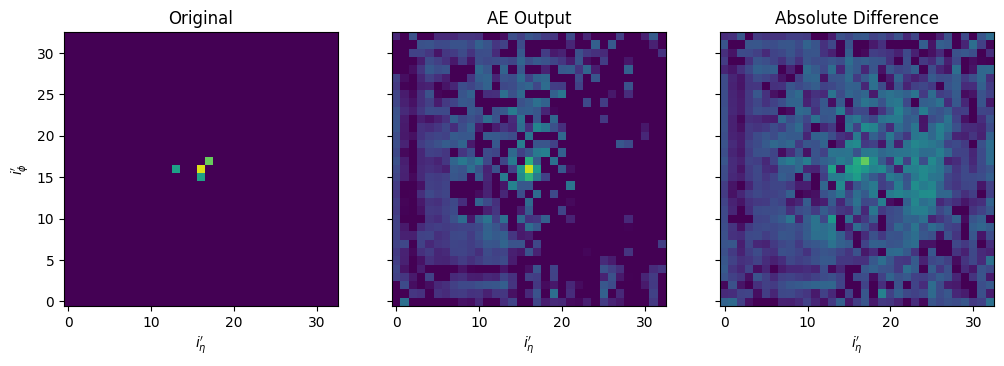

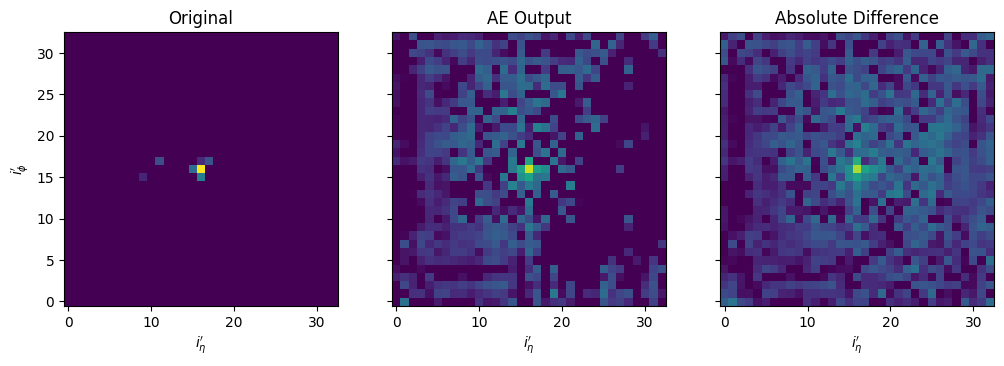

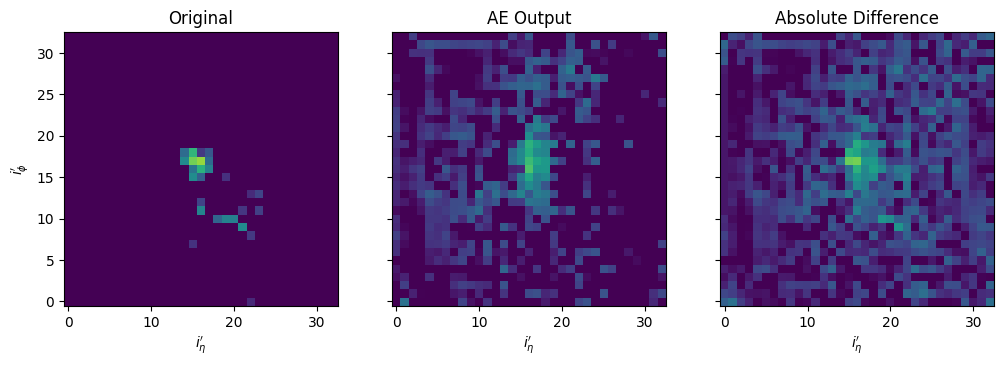

In [ ]:
for i in range(3):
    plot_jet_reconstruction(autoencoder, background[i:i + 1, 0:1])

I know, it looks pretty terrible :)

## Anomaly Detection


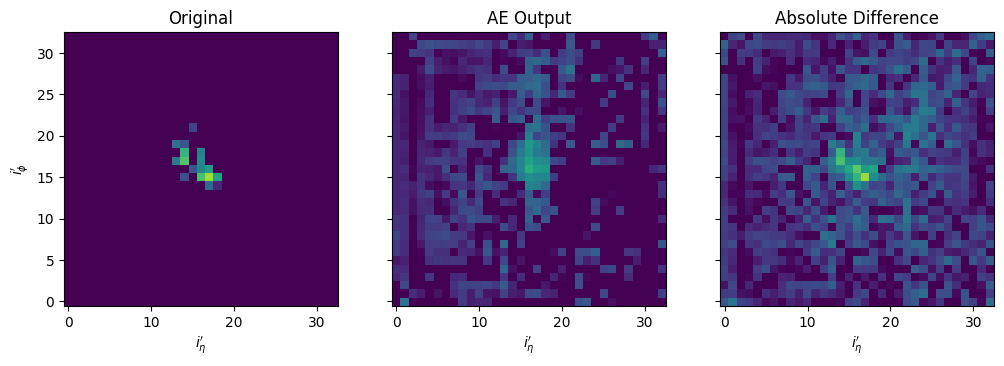

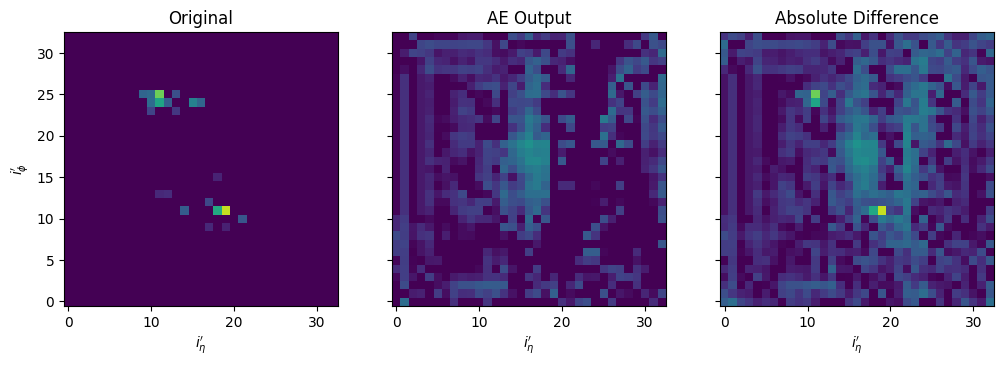

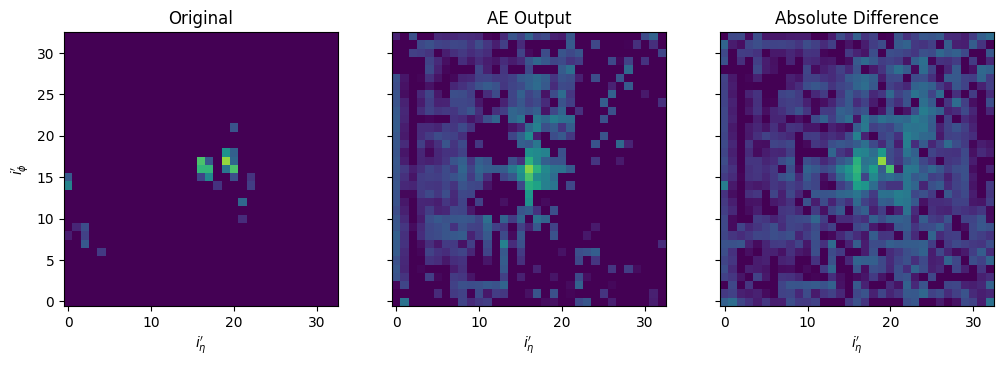

In [ ]:
for i in range(3):
    plot_jet_reconstruction(autoencoder, signal[i:i+1, 0:1])

This feature can be exploited to create an anomaly detection metric: we flag well-reconstructed events as "background" and badly reconstructed ones as "signal". We also use the MSE for this task:

In [3]:
@torch.no_grad()
def autoencoder_roc(autoencoder, signal, background):
    """
    Wrapper around sklearn.metric.roc_curve to compute performance metrics of an autoencoder.
    """

    # Cap background size to avoid running out of CUDA memory. Take it from the end to reduce overlap
    # with the training set.
    background = background[:-2 * len(signal)]

    signal_score = MSE(signal, autoencoder(signal)).cpu()
    background_score = MSE(background, autoencoder(background)).cpu()

    ones = torch.ones(len(signal))
    zeros = torch.zeros(len(background))

    return roc_curve(torch.concat((ones, zeros)), torch.concat((signal_score, background_score)))


def plot_performance(autoencoder, signal, background):
    """
    Plots autoencoder anomaly detection performance metrics.
    """

    fpr, tpr, thr = autoencoder_roc(autoencoder, signal, background)

    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(tpr, 1/fpr, label="Autoencoder")
    ax[0].plot(tpr, 1/tpr, linestyle=":", color="black", label="random")
    ax[0].set_xlabel("Signal Efficiency (True Postive Rate)")
    ax[0].set_ylabel("Background Rejection (1 / False Positive Rate)")
    ax[0].set_yscale("log")

    ax[1].plot(tpr, tpr/(fpr**0.5), label="Autoencoder")
    ax[1].plot(tpr, tpr**0.5, linestyle=":", color="black", label="random")
    ax[1].set_xlabel("Signal Efficiency (True Postive Rate)")
    ax[1].set_ylabel("Significance Improvement")
    ax[1].legend(loc="upper right")

    plt.show()

**NOTE**: **Memory Warning**

These cells process large datasets and plots, which may exceed the free Colab RAM limit and cause runtime crashes. Even though, the code itself is correct — to run it successfully, you’ll need a more powerful runtime (e.g., Colab Pro, T4/A100 GPU, or a machine with more RAM). You can also try reducing dataset size or running cells one by one to avoid memory issues.

/tmp/ipython-input-3387739281.py:28: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(tpr, 1/fpr, label="Autoencoder")
/tmp/ipython-input-3387739281.py:29: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(tpr, 1/tpr, linestyle=":", color="black", label="random")
/tmp/ipython-input-3387739281.py:34: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, tpr/(fpr**0.5), label="Autoencoder")
/tmp/ipython-input-3387739281.py:34: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(tpr, tpr/(fpr**0.5), label="Autoencoder")


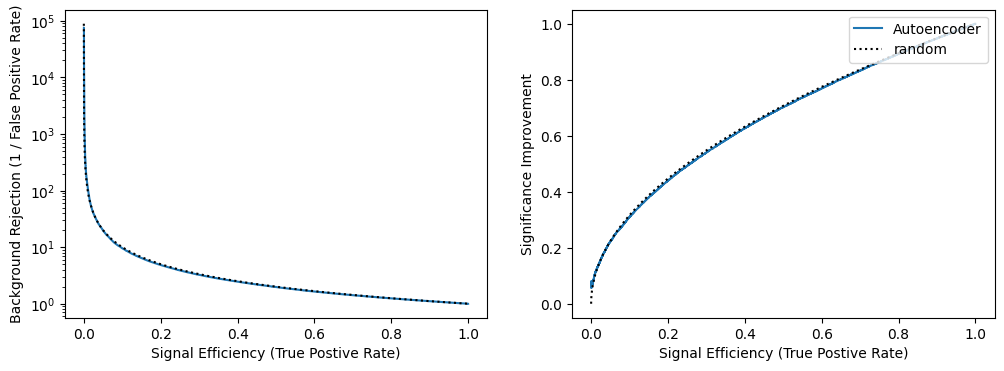

In [18]:
plot_performance(autoencoder, signal, background)

In [ ]:
print("\n" + "="*60)
print("Autoencoder Performance Metrics")
print("="*60)

# ROC curve'den metrikler hesapla
fpr_ae, tpr_ae, thr_ae = autoencoder_roc(autoencoder, signal, background)

# Test için sample hazırla (memory için)
test_signal = signal[:1000]
test_background = background[-2000:-1000]

@torch.no_grad()
def get_mse_scores(ae, sig, bkg):
    """MSE skorlarını hesapla"""
    sig_mse = MSE(sig, ae(sig)).cpu().numpy()
    bkg_mse = MSE(bkg, ae(bkg)).cpu().numpy()
    return sig_mse, bkg_mse

signal_mse, background_mse = get_mse_scores(autoencoder, test_signal, test_background)

# True labels ve scores birleştir
y_true_ae = np.concatenate([np.ones(len(signal_mse)), np.zeros(len(background_mse))])
mse_scores = np.concatenate([signal_mse, background_mse])

# Optimal threshold bul (Youden's J statistic)
J = tpr_ae - fpr_ae
idx_optimal = np.argmax(J)
optimal_thr = thr_ae[idx_optimal]

print(f"\nOptimal MSE Threshold: {optimal_thr:.6f}")
print(f"  (maximizes TPR - FPR)")

# Background MSE'nin farklı percentile'larında değerlendir
percentiles_to_test = [50, 75, 90]

for pct in percentiles_to_test:
    thresh = np.percentile(background_mse, pct)
    y_pred_binary = (mse_scores > thresh).astype(int)

    acc = accuracy_score(y_true_ae, y_pred_binary)
    prec = precision_score(y_true_ae, y_pred_binary)
    rec = recall_score(y_true_ae, y_pred_binary)
    f1 = f1_score(y_true_ae, y_pred_binary)

    print(f"\nThreshold = {thresh:.6f} ({pct}th percentile of background MSE)")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# AUC skoru
auc_ae = roc_auc_score(y_true_ae, mse_scores)
print(f"\nAUC Score: {auc_ae:.4f}")

# MSE dağılımı istatistikleri
print(f"\nMSE Statistics:")
print(f"  Signal:     mean={signal_mse.mean():.6f}, std={signal_mse.std():.6f}")
print(f"  Background: mean={background_mse.mean():.6f}, std={background_mse.std():.6f}")
print(f"  Separation: {(signal_mse.mean() - background_mse.mean())/background_mse.std():.2f}σ")

# Signal efficiency ve background rejection
signal_effs_ae = [0.3, 0.5, 0.7, 0.9]
print("\nSignal Efficiency → Background Rejection:")
for sig_eff in signal_effs_ae:
    idx = np.argmin(np.abs(tpr_ae - sig_eff))
    bkg_rej = 1/fpr_ae[idx]
    print(f"  ε_sig = {sig_eff:.1f} → 1/ε_bkg = {bkg_rej:.2f}")

print("="*60)

# Using signal during training

The way we trained our autoencoder was unrealistic: in practice, there would be some signal in the training data. Autoencoders are claimed to be fairly robust to signal contamination of the training set. Let's check this.


In [20]:
def mix(size, background, signal, signal_fraction):
    """
    Mixes signal and background into a tensor of the specified size, such that fraction of signal events is as specified.
    """

    num_signal = int(size * signal_fraction)
    num_background = size - num_signal
    data = torch.concat((background[:num_background], signal[:num_signal]))
    truth = torch.concat((torch.zeros_like(background[:num_background]), torch.ones_like(signal[:num_signal])))
    perm = torch.randperm(len(data))
    return data[perm], truth[perm]

In [ ]:
mixed_data, _ = mix(12800, background, signal, 0.0)
mixed_autoencoder, _, _ = make_model()
train(mixed_autoencoder, mixed_data, epochs=30)
plot_performance(mixed_autoencoder, signal, background)

Epoch  0: training loss = 1.7688473956659436
Epoch  1: training loss = 0.11128759878920391
Epoch  2: training loss = 0.07279699534410611
Epoch  3: training loss = 0.05800728074973449
Epoch  4: training loss = 0.050245658261701465
Epoch  5: training loss = 0.04552578099537641
Epoch  6: training loss = 0.04216615520999767
Epoch  7: training loss = 0.03952977267908864
Epoch  8: training loss = 0.03740724374074489
Epoch  9: training loss = 0.03550684548099525
Epoch 10: training loss = 0.03382540220627561
Epoch 11: training loss = 0.0323656274122186
Epoch 12: training loss = 0.030985662975581363
Epoch 13: training loss = 0.029697007354116067
Epoch 14: training loss = 0.028311540663708
Epoch 15: training loss = 0.02710644542821683
Epoch 16: training loss = 0.02615770675765816
Epoch 17: training loss = 0.025320818371255882
Epoch 18: training loss = 0.024547082895878702
Epoch 19: training loss = 0.023808837271644734
Epoch 20: training loss = 0.02315410833398346
Epoch 21: training loss = 0.0225

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC Curves comparision
ax = axes[0, 0]
ax.plot(tpr, 1/fpr, label=f"CWoLa (AUC={auc:.3f})", linewidth=2, color='blue')
ax.plot(tpr_ae, 1/fpr_ae, label=f"Autoencoder (AUC={auc_ae:.3f})", linewidth=2, color='green')
ax.plot(tpr, 1/tpr, linestyle=":", color="black", label="random", alpha=0.5)
ax.set_xlabel("Signal Efficiency (True Positive Rate)")
ax.set_ylabel("Background Rejection (1 / False Positive Rate)")
ax.set_yscale("log")
ax.set_title("ROC Curve Comparison")
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Significance Improvement
ax = axes[0, 1]
ax.plot(tpr, tpr/(fpr**0.5), label="CWoLa", linewidth=2, color='blue')
ax.plot(tpr_ae, tpr_ae/(fpr_ae**0.5), label="Autoencoder", linewidth=2, color='green')
ax.plot(tpr, tpr**0.5, linestyle=":", color="black", label="random", alpha=0.5)
ax.set_xlabel("Signal Efficiency (True Positive Rate)")
ax.set_ylabel("Significance Improvement")
ax.set_title("Significance Improvement Comparison")
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# CWoLa predictions distribution
ax = axes[1, 0]
bkg_color = "orange"
signal_color = "fuchsia"
ax.hist(y_pred_test[signal_labels_test == 0], bins=50, alpha=0.6,
        label='background', edgecolor=bkg_color, linewidth=1.5, histtype='step', density=True)
ax.hist(y_pred_test[signal_labels_test == 1], bins=50, alpha=0.6,
        label='signal', edgecolor=signal_color, linewidth=1.5, histtype='step', density=True)
ax.set_xlabel("CWoLa Output Score")
ax.set_ylabel("Density")
ax.set_title("CWoLa Score Distribution")
ax.set_yscale("log")
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Autoencoder MSE distribution
ax = axes[1, 1]
ax.hist(background_mse, bins=50, alpha=0.6,
        label='background', edgecolor=bkg_color, linewidth=1.5, histtype='step', density=True)
ax.hist(signal_mse, bins=50, alpha=0.6,
        label='signal', edgecolor=signal_color, linewidth=1.5, histtype='step', density=True)
ax.set_xlabel("Reconstruction MSE")
ax.set_ylabel("Density")
ax.set_title("Autoencoder MSE Distribution")
ax.set_yscale("log")
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()